# 🔍 AVFF Deepfake Detection Demo

This notebook demonstrates the AVFF (Audio-Visual Feature Fusion) pipeline for video deepfake detection using pre-trained models.

## Pipeline Overview
1. 🔧 Setup & Dependencies
2. 📥 Load & Preprocess Sample Video
3. 🎛️ Build Audio & Visual Encoders
4. 🔁 Cross-Modal Feature Fusion
5. 📦 Reconstruction via Decoder
6. 🧠 Deepfake Classification
7. 🧪 Run Inference
8. 📈 Visualize & Interpret Results

## 1. 🔧 Setup & Dependencies

In [ ]:
!pip install torch torchvision torchaudio transformers timm einops librosa opencv-python matplotlib scikit-learn

In [7]:
import torch
import torch.nn as nn
import torchaudio
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
from transformers import AutoModel, AutoFeatureExtractor
import timm
from einops import rearrange
import timm


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. 📥 Load & Preprocess Sample Video

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1578202].


Frames shape: torch.Size([16, 3, 224, 224])
Mel spectrogram shape: torch.Size([1, 64, 63])


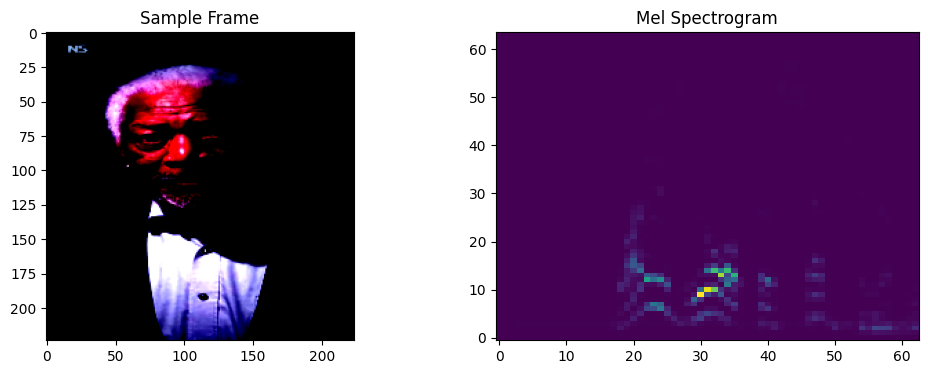

In [24]:
import cv2
import torch
import numpy as np
import torchaudio
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

def extract_frames(video_path, frame_count=16, duration_sec=2):
    """Extract `frame_count` frames from the first `duration_sec` seconds of the video."""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(fps * duration_sec)

    frame_indices = np.linspace(0, total_frames - 1, frame_count, dtype=int)
    frames = []

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = transform(frame)
            frames.append(frame)
    
    cap.release()
    return torch.stack(frames)

def extract_audio(video_path, sample_rate=16000, duration=2.0):
    """Extract waveform and mel spectrogram from audio"""
    temp_audio_path = 'temp_audio.wav'

    # Extract using ffmpeg
    os.system(f"ffmpeg -y -i \"{video_path}\" -t {duration} -vn -ar {sample_rate} -ac 1 -f wav {temp_audio_path}")

    waveform, sr = torchaudio.load(temp_audio_path)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)

    # Convert stereo to mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Trim or pad to fixed duration
    target_len = int(duration * sample_rate)
    if waveform.shape[1] < target_len:
        waveform = torch.nn.functional.pad(waveform, (0, target_len - waveform.shape[1]))
    else:
        waveform = waveform[:, :target_len]

    # Create mel spectrogram (optional if still needed)
    mel_spec = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )(waveform)

    return waveform, mel_spec


# Test with sample.mp4
video_path = 'sample.mp4'
# video_path = 'sample_2.mp4'

frames = extract_frames(video_path, frame_count=16, duration_sec=2)
_, mel_spec = extract_audio(video_path, duration=2.0)

print(f'Frames shape: {frames.shape}')         # Expected: [16, 3, 224, 224]
print(f'Mel spectrogram shape: {mel_spec.shape}')  # Expected: [1, 64, ~time]

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(frames[0].permute(1, 2, 0).numpy())
plt.title('Sample Frame')
plt.subplot(1, 2, 2)
plt.imshow(mel_spec.squeeze().numpy(), aspect='auto', origin='lower')
plt.title('Mel Spectrogram')
plt.show()


## 3. 🎛️ Build Audio & Visual Encoders

We'll use pre-trained models for both audio and visual encoding:

In [20]:
class AudioEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Use Wav2Vec2 for audio encoding
        self.encoder = AutoModel.from_pretrained('facebook/wav2vec2-base')
        self.projection = nn.Linear(768, 512)  # Project to common dimension
        
    def forward(self, x):
        # x: [batch_size, 1, time]
        features = self.encoder(x).last_hidden_state
        # Pool over time dimension
        features = torch.mean(features, dim=1)
        return self.projection(features)
    
class VisualEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)  # <--- disables classifier head
        self.projection = nn.Linear(768, 512)  # Project features

    def forward(self, x):
        # x: [batch_size, frames, channels, height, width]
        batch_size, frames = x.shape[:2]
        x = x.view(-1, *x.shape[2:])  # [B*F, C, H, W]
        features = self.encoder(x)    # Now features.shape == [B*F, 768]
        features = features.view(batch_size, frames, -1)  # [B, F, 768]
        features = torch.mean(features, dim=1)  # Mean-pool over frames
        return self.projection(features)        # [B, 512]

# Initialize encoders
audio_encoder = AudioEncoder().to(device)
visual_encoder = VisualEncoder().to(device)

# Test encoders
with torch.no_grad():
    # waveform should be a 1D or [1, time] tensor
    waveform, _ = torchaudio.load("temp_audio.wav")  # or from your earlier extraction
    audio_input = waveform.squeeze(0).unsqueeze(0).to(device)  # [1, time]
    audio_features = audio_encoder(audio_input)

    visual_features = visual_encoder(frames.unsqueeze(0).to(device))
    
print(f'Audio features shape: {audio_features.shape}')
print(f'Visual features shape: {visual_features.shape}')

Audio features shape: torch.Size([1, 512])
Visual features shape: torch.Size([1, 512])


## 4. 🔁 Cross-Modal Feature Fusion

In [21]:
class CrossModalFusion(nn.Module):
    def __init__(self, dim=512):
        super().__init__()
        self.attention = nn.MultiheadAttention(dim, num_heads=8)
        self.fusion_mlp = nn.Sequential(
            nn.Linear(dim * 2, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )
    
    def forward(self, visual_features, audio_features):
        # Cross-attention
        attn_out, _ = self.attention(
            visual_features.unsqueeze(0),
            audio_features.unsqueeze(0),
            audio_features.unsqueeze(0)
        )
        
        # Fusion
        fused = self.fusion_mlp(torch.cat([visual_features, attn_out.squeeze(0)], dim=1))
        return fused

# Initialize fusion module
fusion = CrossModalFusion().to(device)

# Test fusion
with torch.no_grad():
    fused_features = fusion(visual_features, audio_features)
print(f'Fused features shape: {fused_features.shape}')

Fused features shape: torch.Size([1, 512])


## 5. 📦 Reconstruction via Decoder

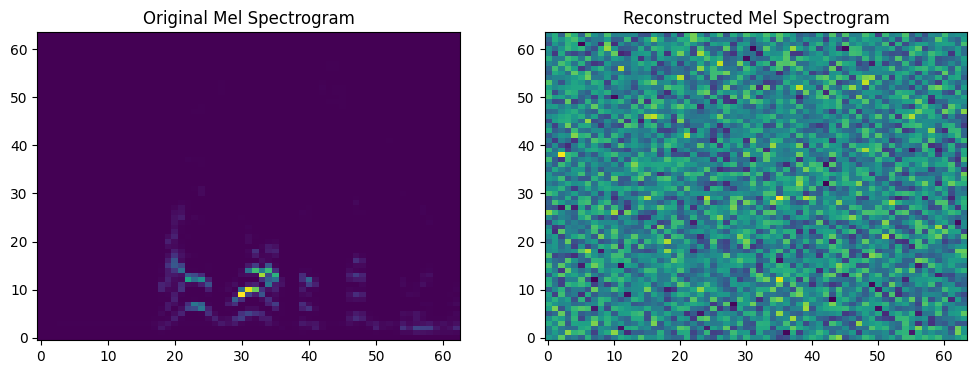

In [22]:
class Decoder(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, 64 * 64)  # Reconstruct mel spectrogram
        )
    
    def forward(self, x):
        return self.decoder(x)

# Initialize decoder
decoder = Decoder().to(device)

# Test reconstruction
with torch.no_grad():
    reconstructed = decoder(fused_features)
    reconstructed = reconstructed.view(-1, 64, 64)

# Visualize reconstruction
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mel_spec.squeeze().numpy(), aspect='auto', origin='lower')
plt.title('Original Mel Spectrogram')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed.squeeze().cpu().numpy(), aspect='auto', origin='lower')
plt.title('Reconstructed Mel Spectrogram')
plt.show()

## 6. 🧠 Deepfake Classification

In [23]:
class Classifier(nn.Module):
    def __init__(self, input_dim=512):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.classifier(x)

# Initialize classifier
classifier = Classifier().to(device)

# Test classification
with torch.no_grad():
    prediction = classifier(fused_features)
print(f'Prediction: {prediction.item():.4f}')

Prediction: 0.5437


## 7. 🧪 Run Inference on a Video

In [25]:
def process_video(video_path):
    # Extract frames and audio
    frames = extract_frames(video_path)
    waveform, mel_spec = extract_audio(video_path)  # ← returns waveform now!

    # Move to device
    frames = frames.unsqueeze(0).to(device)
    waveform = waveform.squeeze(0).unsqueeze(0).to(device)  # [1, time]

    # Get features
    with torch.no_grad():
        audio_features = audio_encoder(waveform)
        visual_features = visual_encoder(frames)
        fused_features = fusion(visual_features, audio_features)
        prediction = classifier(fused_features)

    return {
        'prediction': prediction.item(),
        'audio_features': audio_features.cpu().numpy(),
        'visual_features': visual_features.cpu().numpy(),
        'fused_features': fused_features.cpu().numpy()
    }


# Test on a video
video_path = 'sample.mp4'  # Replace with your video path
results = process_video(video_path)
print(f'Deepfake probability: {results["prediction"]:.4f}')

Deepfake probability: 0.5231


## 8. 📈 Visualize & Interpret Results

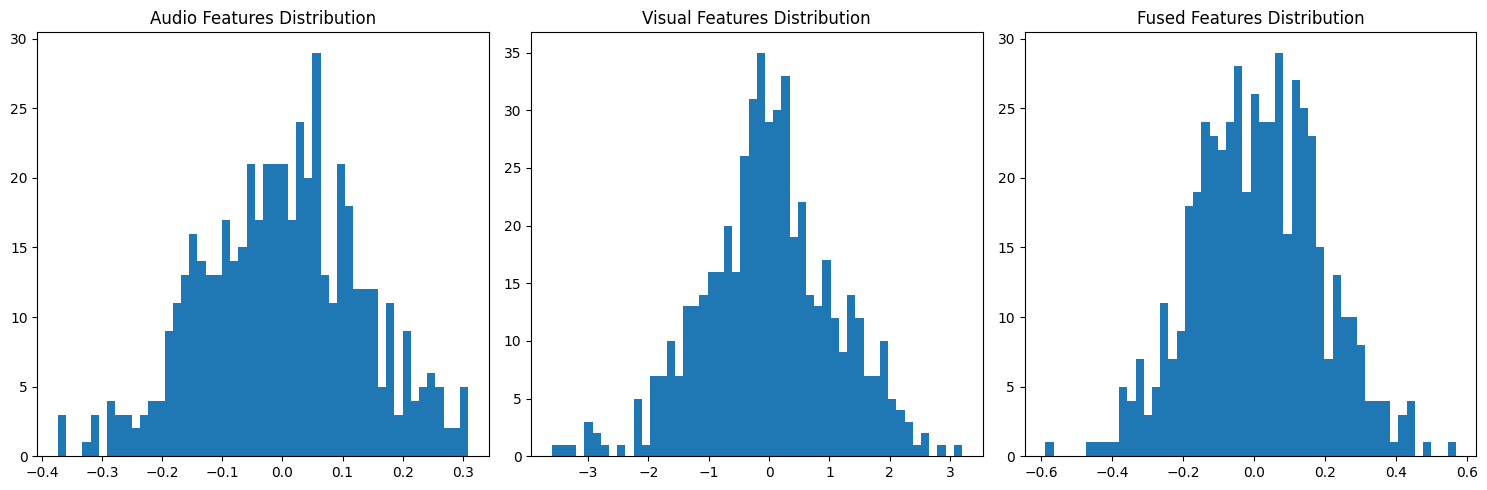

In [26]:
def visualize_features(results):
    # Plot feature distributions
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(results['audio_features'].flatten(), bins=50)
    plt.title('Audio Features Distribution')
    
    plt.subplot(1, 3, 2)
    plt.hist(results['visual_features'].flatten(), bins=50)
    plt.title('Visual Features Distribution')
    
    plt.subplot(1, 3, 3)
    plt.hist(results['fused_features'].flatten(), bins=50)
    plt.title('Fused Features Distribution')
    
    plt.tight_layout()
    plt.show()

# Visualize features
visualize_features(results)